## Aufgabe 2 : Schätzung, Test, Prognose und Prognosefehler im multivariaten Modell ##

**Verwendeter Datensatz:** https://www.kaggle.com/datasets/mirichoi0218/insurance

**Ziel:** Vorhersage auf Basis verschiedener unabhängiger Variablen

**Allgemeines Vorgehen:**
1. Daten laden und aufbereiten
2. EDA (Vorstellung des Datensatzes) # jasmina
3. Modellspezifikation # jasmina
4. Modellschätzung # jasmina
6. F-Test # tina
7. Prognose (Fehler) und Prognoseintervalle # tina
8. Test der Annahmen bivariat + (Multikollinearität, Strukturbrüche, Homoskedastizität, Autokorrelation, Normalverteilung) # martin
9. Interpretation

In [45]:
# import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from scipy.stats import levene
from sklearn.feature_selection import f_regression
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

### 1. Daten laden und aufbereiten

In [46]:
# load data
insurance_data = pd.read_csv('insurance.csv')
print(insurance_data.head())
print()
print("shape: ", insurance_data.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

shape:  (1338, 7)


In [47]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [48]:
# missing data points
print('Missing data points:')
print(insurance_data.isnull().sum())

Missing data points:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [49]:
# one hot encoding
data = pd.get_dummies(insurance_data)
print(data.head())

   age     bmi  children      charges  sex_female  sex_male  smoker_no  \
0   19  27.900         0  16884.92400           1         0          0   
1   18  33.770         1   1725.55230           0         1          1   
2   28  33.000         3   4449.46200           0         1          1   
3   33  22.705         0  21984.47061           0         1          1   
4   32  28.880         0   3866.85520           0         1          1   

   smoker_yes  region_northeast  region_northwest  region_southeast  \
0           1                 0                 0                 0   
1           0                 0                 0                 1   
2           0                 0                 0                 1   
3           0                 0                 1                 0   
4           0                 0                 1                 0   

   region_southwest  
0                 1  
1                 0  
2                 0  
3                 0  
4                 

In [50]:
data.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [51]:
df_num = data[['age', 'bmi', 'children', 'charges']]
df_sex = [['sex_female', 'sex_male']]
df_smoker = data[['smoker_no', 'smoker_yes']]
df_region = data[['region_northeast', 'region_northwest','region_southeast', 'region_southwest']]

### 2. EDA (Vorstellung des Datensatzes)

In [52]:
# Summary statistics
#all
data.describe().round(2)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00,1338.0,1338.0,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42,0.49,0.51,0.8,0.2,0.24,0.24,0.27,0.24
std,14.05,6.10,1.21,12110.01,0.50,0.50,0.4,0.4,0.43,0.43,0.45,0.43
min,18.00,15.96,0.00,1121.87,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
25%,27.00,26.30,0.00,4740.29,0.00,0.00,1.0,0.0,0.00,0.00,0.00,0.00
50%,39.00,30.40,1.00,9382.03,0.00,1.00,1.0,0.0,0.00,0.00,0.00,0.00
75%,51.00,34.69,2.00,16639.91,1.00,1.00,1.0,0.0,0.00,0.00,1.00,0.00
max,64.00,53.13,5.00,63770.43,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00


In [53]:
#boxplots zu den variablen

# -> to dos

In [54]:
data[['age', 'bmi', 'children', 'charges']].describe().round(2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


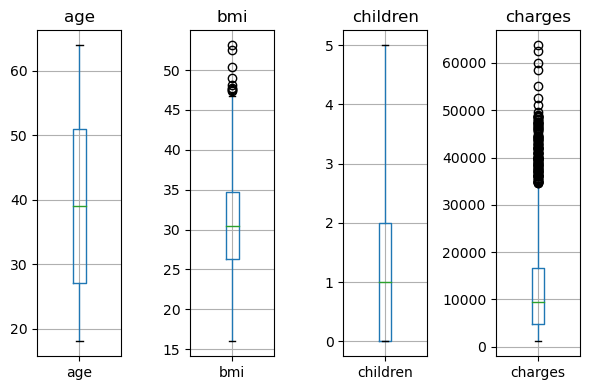

In [55]:
# Box und Whiskerplots
df = data[['age', 'bmi', 'children', 'charges']]

plt.figure(figsize=(6, 4))  

num_columns = len(df.columns) 

# Für jede Spalte im DataFrame einen Boxplot erstellen
for i, column in enumerate(df.columns):
    plt.subplot(1, num_columns, i+1)  #Für jede Spalte ein eigenen Plot
    df.boxplot(column)  
    plt.title(column)  

plt.tight_layout() 
plt.show()  

In [56]:
data[['sex_female', 'sex_male', 'smoker_no', 'smoker_yes']].describe().round(2)

,sex_female,sex_male,smoker_no,smoker_yes
count,1338.00,1338.00,1338.0,1338.0
mean,0.49,0.51,0.8,0.2
std,0.50,0.50,0.4,0.4
min,0.00,0.00,0.0,0.0
25%,0.00,0.00,1.0,0.0
50%,0.00,1.00,1.0,0.0
75%,1.00,1.00,1.0,0.0
max,1.00,1.00,1.0,1.0


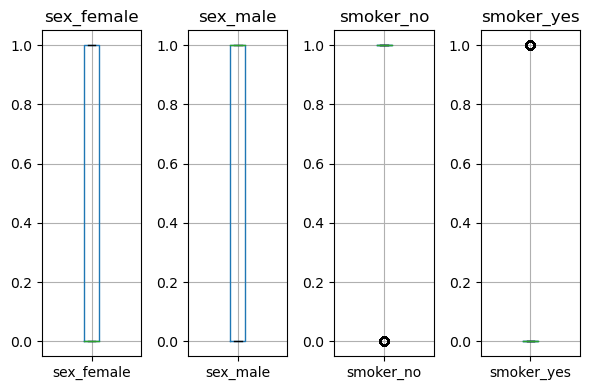

In [57]:
# Box und Whiskerplots
df = data[['sex_female', 'sex_male', 'smoker_no', 'smoker_yes']]

plt.figure(figsize=(6, 4))  

num_columns = len(df.columns) 

# Für jede Spalte im DataFrame einen Boxplot erstellen
for i, column in enumerate(df.columns):
    plt.subplot(1, num_columns, i+1)  #Für jede Spalte ein eigenen Plot
    df.boxplot(column)  
    plt.title(column)  

plt.tight_layout() 
plt.show()  

In [58]:
data[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']].describe().round(2)

,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.00,1338.00,1338.00,1338.00
mean,0.24,0.24,0.27,0.24
std,0.43,0.43,0.45,0.43
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00
75%,0.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00


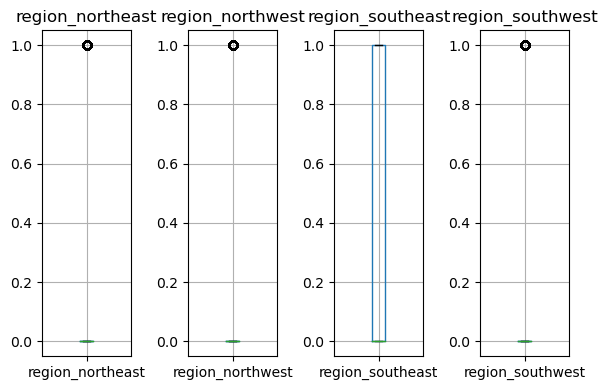

In [59]:
# Box und Whiskerplots
df = data[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']]

plt.figure(figsize=(6, 4))  

num_columns = len(df.columns) 

# Für jede Spalte im DataFrame einen Boxplot erstellen
for i, column in enumerate(df.columns):
    plt.subplot(1, num_columns, i+1)  #Für jede Spalte ein eigenen Plot
    df.boxplot(column)  
    plt.title(column)  

plt.tight_layout() 
plt.show()  

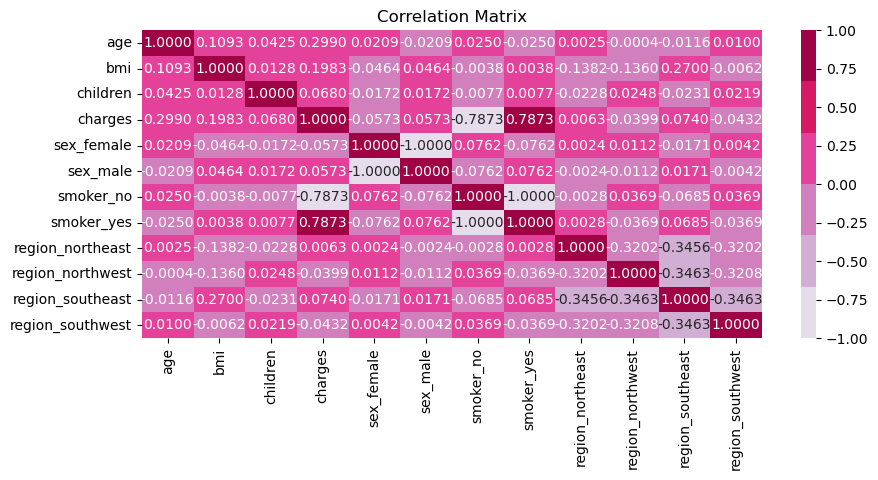

In [60]:
# Data Visualization

num_values = data.select_dtypes(include=[np.number]) # leave out cat values

# Correlation Matrix
correlation_matrix = num_values.corr()

colormap = sns.color_palette("PuRd") 

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap = colormap, annot=True, fmt=".4f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

Korrelation die auf charges interessant sind
- age: 0.2990
- bmi: 0.1983
- children: 0.0680
- female: -0.0573
- male: 0.0573
- smoker no: -0.7873
- smoker yes: 0.7873
- region ne: 0.0063
- region nw: -0.0399
- region se: 0.0740
- region sw: -0.0432


am interessantesten Varibalen, mit den "höchsten" Werten sind:
- smoker yes: 0.7873
- age: 0.2990
- bmi: 0.1983

In [61]:
#weitere plots

### 3. Modellspezifikation und 4. Modellschätzung

In [62]:
# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(data[['age', 'bmi', 'smoker_yes']], data['charges'], test_size=0.2, random_state=42)

In [63]:
# Specify the model (bivariate linear regression)
# Fit the linear regression model

In [64]:
model_lr = sm.OLS(y_train, X_train)
results = model_lr.fit()

In [65]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              2379.
Date:                Mon, 13 May 2024   Prob (F-statistic):                        0.00
Time:                        17:33:54   Log-Likelihood:                         -10908.
No. Observations:                1070   AIC:                                  2.182e+04
Df Residuals:                    1067   BIC:                                  2.184e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [66]:
ypred = results.predict(X_test)
print(ypred[:5])

764      9905.548981
887      8273.435254
890     36864.427153
1293    10126.045150
259     28026.000768
dtype: float64


#### other lm

In [67]:

lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = lm_model.predict(X_test)

print("Prediction charges anhand age:")
print(y_pred[:4])
print(y_pred[:4].round(2))

Prediction charges anhand age:
[ 8184.0414679   7431.00100108 37346.43709938  8629.52830485]
[ 8184.04  7431.   37346.44  8629.53]


In [69]:
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)
print('Mean squared error for age:', mse)
print('R2 score for age:', r2)
print("Intercept:", lm_model.intercept_)
print("Coefficient:", lm_model.coef_[0])

Mean squared error for age: 34512843.88
R2 score for age: 0.7777
Intercept: -11707.802334583159
Coefficient: 259.4102046230588


### 5. (Test der Annahmen (aus bivariater Analyse))

### 6. F-Test

### 7. Prognose (Fehler) und Prognoseintervalle

### 8. Test der Annahmen (Multikollinearität, Strukturbrüche, Homoskedastizität, Autokorrelation, Normalverteilung)